<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Image_classification_with_Vision_Transformer_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [1]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
n_classes = 100
input_shape = (32,32,3)
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar100.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

169001437/169001437 [==============================] - 2s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
x_train[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [195, 205, 193],
        [212, 224, 204],
        [182, 194, 167]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [170, 176, 150],
        [161, 168, 130],
        [146, 154, 113]],

       [[255, 255, 255],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [189, 199, 169],
        [166, 178, 130],
        [121, 133,  87]],

       ...,

       [[148, 185,  79],
        [142, 182,  57],
        [140, 179,  60],
        ...,
        [ 30,  17,   1],
        [ 65,  62,  15],
        [ 76,  77,  20]],

       [[122, 157,  66],
        [120, 155,  58],
        [126, 160,  71],
        ...,
        [ 22,  16,   3],
        [ 97, 112,  56],
        [141, 161,  87]],

       [[ 87, 122,  41],
        [ 88, 122,  39],
        [101, 134,  56],
        ...,
        [ 34,  36,  10],
        [105, 133,  59],
        [138, 173,  79]]

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.RandomRotation(factor = 0.02),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ])

In [7]:
data_augmentation.layers[0].adapt(x_train)

**Implement multilayer perceptron (MLP)**

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation = tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

**Implement patch creation as a layer**

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


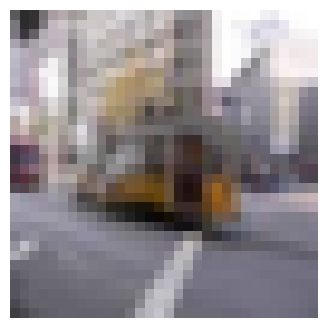

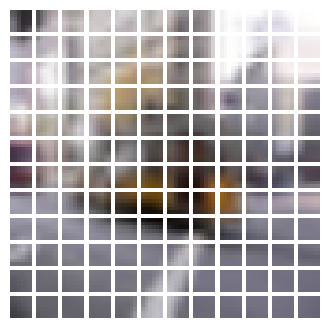

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
img = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(img.astype("uint8"))
plt.axis("off")

resize = tf.image.resize(tf.convert_to_tensor([img]), size = (image_size, image_size))
patches = Patches(patch_size)(resize)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch, (patch_size,  patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
###Implement the patch encoding layer###

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

**Build the ViT model**

In [20]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(n_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 79s 371ms/step - loss: 4.4646 - accuracy: 0.0476 - top-5-accuracy: 0.1652 - val_loss: 3.8744 - val_accuracy: 0.1058 - val_top-5-accuracy: 0.3046
Epoch 2/100
176/176 [==============================] - 64s 363ms/step - loss: 3.9483 - accuracy: 0.0952 - top-5-accuracy: 0.2895 - val_loss: 3.5619 - val_accuracy: 0.1620 - val_top-5-accuracy: 0.4106
Epoch 3/100
176/176 [==============================] - 69s 391ms/step - loss: 3.6953 - accuracy: 0.1316 - top-5-accuracy: 0.3659 - val_loss: 3.3783 - val_accuracy: 0.1942 - val_top-5-accuracy: 0.4524
Epoch 4/100
176/176 [==============================] - 66s 375ms/step - loss: 3.5242 - accuracy: 0.1580 - top-5-accuracy: 0.4130 - val_loss: 3.1880 - val_accuracy: 0.2220 - val_top-5-accuracy: 0.5154
Epoch 5/100
176/176 [==============================] - 69s 390ms/step - loss: 3.3739 - accuracy: 0.1842 - top-5-accuracy: 0.4566 - val_loss: 3.0363 - val_accuracy: 0.2638 - val_top-5-accuracy: 0.5496
